## Lab | Making predictions with logistic regression
In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

##### Import database

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila' #tells mysql that i will use a sql database
engine = create_engine(connection_string)

#### 1. Getting the data
Create a query to get the list of films and a boolean indicating if it was rented last month (August 2005). This would be our target variable.

In [3]:
# 1. Get a list of all the titles
# 2. 

In [4]:
query2 = '''SELECT f.film_id, r.inventory_id, r.rental_id, r.rental_date,  f.title, f.language_id, f.rental_duration, f.rental_rate, f.length, f.replacement_cost, f.rating, f.special_features, c.name,
SUM(CASE 
WHEN YEAR(rental_date) = 2005 AND MONTH(rental_date) = 5
THEN 1
ELSE 0
END) AS day_type
FROM rental r
INNER JOIN inventory i USING (inventory_id)
RIGHT JOIN film f USING (film_id)
INNER JOIN film_category fc USING (film_id)
INNER JOIN category c USING (category_id)
GROUP BY f.title;'''

data_all = pd.read_sql_query(query2, engine)
data_all.shape
data_all.head()

,film_id,inventory_id,rental_id,rental_date,title,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,name,day_type
0,19,93.0,10895.0,2005-08-02 01:16:59,AMADEUS HOLY,1,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,1.0
1,21,102.0,207.0,2005-05-26 08:04:38,AMERICAN CIRCUS,1,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,2.0
2,29,142.0,1123.0,2005-05-31 16:48:43,ANTITRUST TOMATOES,1,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,2.0
3,38,NaN,NaN,NaT,ARK RIDGEMONT,1,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0.0
4,56,248.0,3309.0,2005-06-21 08:00:49,BAREFOOT MANCHURIAN,1,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,1.0


In [5]:
data1 = pd.read_sql('''SELECT language_id, name
FROM language;''', engine)
data1.shape

(6, 2)

#### 2. Analysing the data

In [6]:
data_all['day_type'].value_counts()

1.0    355
0.0    314
2.0    225
3.0     76
4.0     27
5.0      3
Name: day_type, dtype: int64

In [7]:
data_all['day_type'] = data_all['day_type'].apply(lambda x: 1 if x > 0 else 0)
data_all['day_type'].head()

0    1
1    1
2    1
3    0
4    1
Name: day_type, dtype: int64

In [8]:
data_all.dtypes

film_id                      int64
inventory_id               float64
rental_id                  float64
rental_date         datetime64[ns]
title                       object
language_id                  int64
rental_duration              int64
rental_rate                float64
length                       int64
replacement_cost           float64
rating                      object
special_features            object
name                        object
day_type                     int64
dtype: object

In [9]:
data_all = pd.DataFrame.merge(data_all,data1,on= 'language_id')
data_all.head()

,film_id,inventory_id,rental_id,rental_date,title,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,name_x,day_type,name_y
0,19,93.0,10895.0,2005-08-02 01:16:59,AMADEUS HOLY,1,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,1,English
1,21,102.0,207.0,2005-05-26 08:04:38,AMERICAN CIRCUS,1,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,1,English
2,29,142.0,1123.0,2005-05-31 16:48:43,ANTITRUST TOMATOES,1,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,1,English
3,38,NaN,NaN,NaT,ARK RIDGEMONT,1,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0,English
4,56,248.0,3309.0,2005-06-21 08:00:49,BAREFOOT MANCHURIAN,1,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,1,English


In [10]:
# Drop the columns we don't need
data_all = data_all.drop(columns = ['film_id', 'inventory_id', 'rental_id', 'language_id', 'rental_date'])

In [11]:
# Change rental duration to categorical
data_all['rental_duration'] = data_all['rental_duration'].astype('object')
data_all['rental_rate'] = data_all['rental_rate'].astype('object')# This will be treated as categorical

In [12]:
# Rename columns
data_all.columns = ['title', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features', 'category', 'target_col', 'language']

In [13]:
#data_all['target_col'] = data_all['target_col'].apply(lambda x: str(x))

In [14]:
data_all.dtypes

title                object
rental_duration      object
rental_rate          object
length                int64
replacement_cost    float64
rating               object
special_features     object
category             object
target_col            int64
language             object
dtype: object

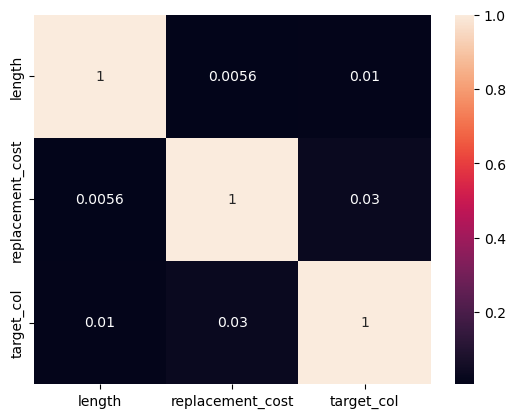

In [15]:
# Correlation matrix - check for multicollinearity

import matplotlib.pyplot as plt
import seaborn as sns 
correlations_matrix = data_all.corr()   
correlations_matrix

#sonra heatmapte  
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [16]:
# Get rid of replacement_cost and length
data_all = data_all.drop(['replacement_cost', 'length'], axis = 1 )

In [17]:
data_all['special_features'].value_counts()

Trailers,Commentaries,Behind the Scenes                   79
Trailers,Commentaries                                     72
Trailers                                                  72
Trailers,Behind the Scenes                                72
Deleted Scenes,Behind the Scenes                          71
Commentaries,Behind the Scenes                            70
Behind the Scenes                                         70
Commentaries,Deleted Scenes,Behind the Scenes             66
Trailers,Deleted Scenes                                   66
Commentaries,Deleted Scenes                               65
Trailers,Commentaries,Deleted Scenes                      64
Commentaries                                              62
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    61
Deleted Scenes                                            61
Trailers,Deleted Scenes,Behind the Scenes                 49
Name: special_features, dtype: int64

In [18]:
data_all = data_all.drop(['special_features', 'title'], axis = 1)

#### 3. 
Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

##### y/x Split

In [19]:
# y/X split
y = data_all['target_col']
X = data_all.drop(['target_col'], axis = 1)

In [20]:
X.dtypes

rental_duration    object
rental_rate        object
rating             object
category           object
language           object
dtype: object

In [21]:
y.value_counts()

1    686
0    314
Name: target_col, dtype: int64

In [22]:
# Test/Train Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1234)

##### Scaling our data

In [23]:
# # 1. Numercial values

# import numpy as np
# from sklearn.preprocessing import MinMaxScaler
# # from sklearn.preprocessing import StandardScaler

# # 1. Create the numerical values
# X_train_num = X_train.select_dtypes(include = np.number)

# # 2. Scaling data
# transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

# X_train_normalized = transformer.transform(X_train_num)

# # 3. Create a new DATAFRAME
# X_train_norm = pd.DataFrame(X_train_normalized, columns = X_train_num.columns)

In [24]:
# X_train_norm.columns = X_train_num.columns
# X_train_norm.head()

In [25]:
X_train_cat = X_train.select_dtypes(include = object)
X_train_cat.head()

,rental_duration,rental_rate,rating,category,language
646,4,2.99,PG-13,Horror,English
777,6,0.99,NC-17,New,English
278,3,2.99,G,Comedy,English
960,5,4.99,PG-13,Travel,English
411,5,4.99,NC-17,Drama,English


In [26]:
# 2. Categorical values

X_train_cat = X_train.select_dtypes(include = object)
# encode categoricals
from sklearn.preprocessing import OneHotEncoder
# Step 1
encoder = OneHotEncoder().fit(X_train_cat)
cols = encoder.get_feature_names(input_features=X_train_cat.columns)
X_train_cat = pd.DataFrame(encoder.transform(X_train_cat).toarray(),columns=cols)
X_train_cat.head()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,...,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,language_English
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
# Concatenate our X train transformed
import numpy as np
X_train_transformed = np.concatenate([X_train_cat], axis=1) # i could also use pd.concat - they are the same, np.concatenate will also treat them as arrays

In [28]:
X_train_transformed

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

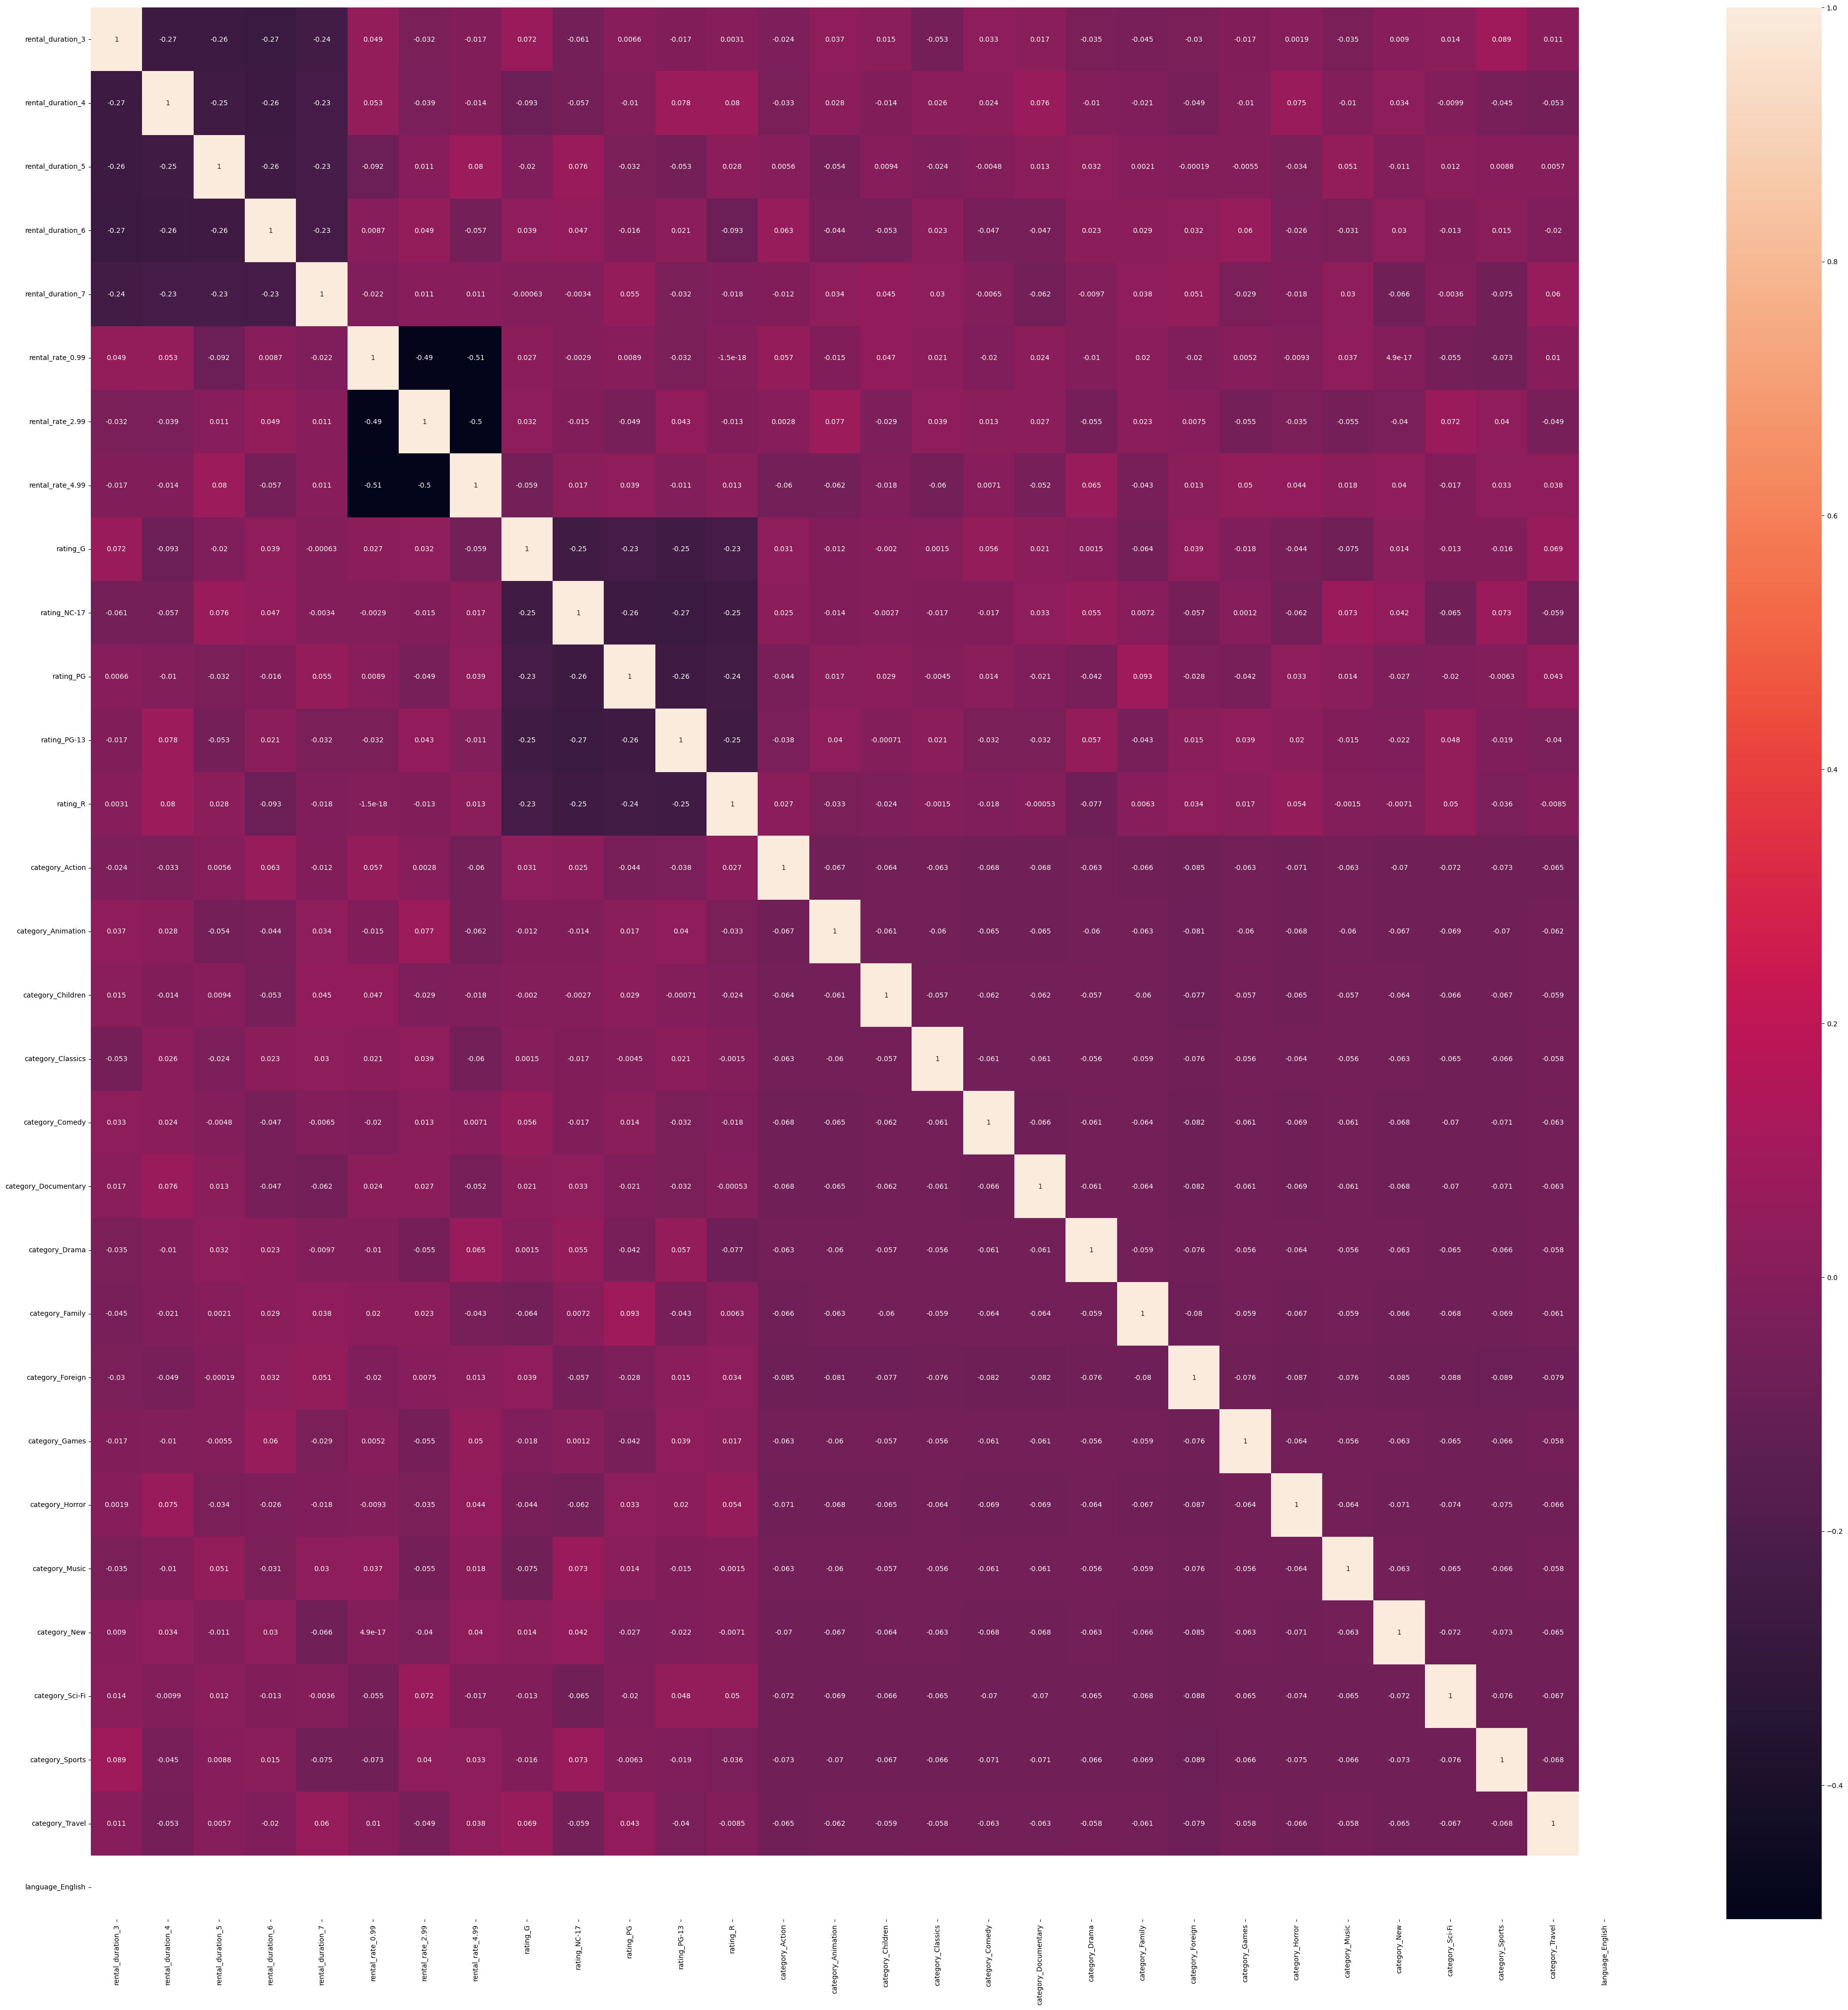

In [29]:
correlations_matrix = X_train_cat.corr() 
fig, ax = plt.subplots(figsize = (50,50))
correlations_matrix

#sonra heatmapte  
sns.heatmap(correlations_matrix, annot=True)
plt.show()

In [30]:
# Get rid of category values?

#### 4.  Create a logistic regression model
to predict this variable from the cleaned data.

In [31]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression(random_state=0, solver='lbfgs') #solver here is the dfault one - choice of algorithm
#LogReg.fit(X_train_transformed, y_train) # call the regression model classification

In [32]:
LogReg.fit(X_train_transformed, y_train)

LogisticRegression(random_state=0)

In [33]:
display(y_train.shape)
X_train_transformed.shape

(600,)

(600, 30)

##### Encode the test_numericals and test_categoricals

In [34]:
# X_test_num = X_test.select_dtypes(include = np.number)

# # Scaling data
# # we use the transformer that was trained on the training data
# X_test_normalized = transformer.transform(X_test_num)
# X_test_norm = pd.DataFrame(X_test_normalized)

In [35]:
# for categoricals
X_test_cat = X_test.select_dtypes(include = object)

encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test = pd.DataFrame(encoded_test_cat, columns=cols)
onehot_encoded_test.head()

,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,...,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,language_English
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
X_test_transformed = np.concatenate([onehot_encoded_test], axis=1)

In [37]:
predictions = LogReg.predict(X_test_transformed)
display(predictions)
LogReg.score(X_test_transformed, y_test)

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

0.6775

In [38]:
print(y_test.value_counts())

1    278
0    122
Name: target_col, dtype: int64


In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[ 10, 112],
       [ 17, 261]])

In [61]:
### IT SEEMS LIKE I AM ABLE TO PREDICT THE NOT RENTED MOVIES OUT BUT NOT WHICH MOVIE WILL BE RENTED

##### 1. KNN classifier

In [40]:
from sklearn import neighbors
clf = neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform')
clf.fit(X_train_transformed, y_train)
predictions_clf = clf.predict(X_test_transformed)
clf.score(X_test_transformed, y_test)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

0.5875

In [41]:
confusion_matrix(y_test, predictions_clf)

array([[ 22, 100],
       [ 65, 213]])

#### Oberservation:
It seems like I can correctly predict the movies that will not be rented but not the ones that will be rented....

##### 2. Get data from June


In [42]:
query3 = '''SELECT f.film_id, r.inventory_id, r.rental_id, r.rental_date,  f.title, f.language_id, f.rental_duration, f.rental_rate, f.length, f.replacement_cost, f.rating, f.special_features, c.name,
SUM(CASE 
WHEN YEAR(rental_date) = 2005 AND MONTH(rental_date) = 6
THEN 1
ELSE 0
END) AS day_type
FROM rental r
INNER JOIN inventory i USING (inventory_id)
RIGHT JOIN film f USING (film_id)
INNER JOIN film_category fc USING (film_id)
INNER JOIN category c USING (category_id)
GROUP BY f.title'''

data_june = pd.read_sql_query(query3, engine)
data_june.shape
data_june.head()

,film_id,inventory_id,rental_id,rental_date,title,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,name,day_type
0,19,93.0,10895.0,2005-08-02 01:16:59,AMADEUS HOLY,1,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,4.0
1,21,102.0,207.0,2005-05-26 08:04:38,AMERICAN CIRCUS,1,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,3.0
2,29,142.0,1123.0,2005-05-31 16:48:43,ANTITRUST TOMATOES,1,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,2.0
3,38,NaN,NaN,NaT,ARK RIDGEMONT,1,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0.0
4,56,248.0,3309.0,2005-06-21 08:00:49,BAREFOOT MANCHURIAN,1,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,3.0


In [43]:
data_june = pd.DataFrame.merge(data_june,data1,on= 'language_id')
data_june.head()

,film_id,inventory_id,rental_id,rental_date,title,language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,name_x,day_type,name_y
0,19,93.0,10895.0,2005-08-02 01:16:59,AMADEUS HOLY,1,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,4.0,English
1,21,102.0,207.0,2005-05-26 08:04:38,AMERICAN CIRCUS,1,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,3.0,English
2,29,142.0,1123.0,2005-05-31 16:48:43,ANTITRUST TOMATOES,1,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,2.0,English
3,38,NaN,NaN,NaT,ARK RIDGEMONT,1,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0.0,English
4,56,248.0,3309.0,2005-06-21 08:00:49,BAREFOOT MANCHURIAN,1,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,3.0,English


In [44]:
data_june = data_june.drop(columns = ['film_id', 'inventory_id', 'rental_id', 'language_id', 'rental_date'])

In [45]:
data_june.head()
data_june['rental_duration'] = data_june['rental_duration'].astype('object')
data_june['rental_rate'] = data_june['rental_rate'].astype('object')

In [46]:
data_june.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,name_x,day_type,name_y
0,AMADEUS HOLY,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,4.0,English
1,AMERICAN CIRCUS,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,3.0,English
2,ANTITRUST TOMATOES,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,2.0,English
3,ARK RIDGEMONT,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0.0,English
4,BAREFOOT MANCHURIAN,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,3.0,English


In [47]:
data_june['day_type'] = data_june['day_type'].apply(lambda x: 1 if x > 0 else 0)
data_june['day_type'].head()

0    1
1    1
2    1
3    0
4    1
Name: day_type, dtype: int64

In [48]:
data_june['target_col'] = data_june['target_col'].apply(lambda x: str(x))

In [48]:
data_june.columns = ['title', 'rental_duration', 'rental_rate', 'length', 'replacement_cost', 'rating', 'special_features', 'category', 'target_col', 'language']

In [49]:
data_june.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,category,target_col,language
0,AMADEUS HOLY,6,0.99,113,20.99,PG,"Commentaries,Deleted Scenes,Behind the Scenes",Action,1,English
1,AMERICAN CIRCUS,3,4.99,129,17.99,R,"Commentaries,Behind the Scenes",Action,1,English
2,ANTITRUST TOMATOES,5,2.99,168,11.99,NC-17,"Trailers,Commentaries,Deleted Scenes",Action,1,English
3,ARK RIDGEMONT,6,0.99,68,25.99,NC-17,"Trailers,Commentaries,Deleted Scenes,Behind th...",Action,0,English
4,BAREFOOT MANCHURIAN,6,2.99,129,15.99,G,"Trailers,Commentaries",Action,1,English


In [50]:
data_june = data_june.drop(['special_features', 'title'], axis = 1)

In [51]:
data_june = data_june.drop(['length', 'replacement_cost'], axis = 1)

##### y/X split

In [52]:
y_june = data_june['target_col']
X_june= data_june.drop(['target_col'], axis = 1)

In [53]:
display(X_june)
display(X)

,rental_duration,rental_rate,rating,category,language
0,6,0.99,PG,Action,English
1,3,4.99,R,Action,English
2,5,2.99,NC-17,Action,English
3,6,0.99,NC-17,Action,English
4,6,2.99,G,Action,English
...,...,...,...,...,...
995,7,0.99,PG-13,Travel,English
996,3,2.99,R,Travel,English
997,7,0.99,NC-17,Travel,English
998,7,2.99,R,Travel,English


,rental_duration,rental_rate,rating,category,language
0,6,0.99,PG,Action,English
1,3,4.99,R,Action,English
2,5,2.99,NC-17,Action,English
3,6,0.99,NC-17,Action,English
4,6,2.99,G,Action,English
...,...,...,...,...,...
995,7,0.99,PG-13,Travel,English
996,3,2.99,R,Travel,English
997,7,0.99,NC-17,Travel,English
998,7,2.99,R,Travel,English


In [54]:
# X_junN = X_june.select_dtypes(include = np.number)

# # Scaling data
# # we use the transformer that was trained on the training data
# X_normalized_june = transformer.transform(X_junN)
# X_norm_june = pd.DataFrame(X_normalized_june)

In [55]:
X_june_cat = X_june.select_dtypes(include = object)

encoded_june_cat = encoder.transform(X_june_cat).toarray()
onehot_encoded_june = pd.DataFrame(encoded_june_cat, columns=cols)
onehot_encoded_june.head()

,rental_duration_3,rental_duration_4,rental_duration_5,rental_duration_6,rental_duration_7,rental_rate_0.99,rental_rate_2.99,rental_rate_4.99,rating_G,rating_NC-17,...,category_Family,category_Foreign,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,language_English
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [56]:
X_june_transformed = np.concatenate([onehot_encoded_june], axis=1)

In [57]:
y_train.head()

646    0
777    1
278    1
960    1
411    1
Name: target_col, dtype: int64

In [58]:
y_june.head()

0    1
1    1
2    1
3    0
4    1
Name: target_col, dtype: int64

In [59]:
predictions_june = LogReg.predict(X_june_transformed)
display(predictions_june)
LogReg.score(X_june_transformed, y_june)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

0.857

In [60]:
confusion_matrix(y_june, predictions_june)

array([[  6,  94],
       [ 49, 851]])